# Instructions for Tag-Along Project

Stability of the Grid System

Electrical grids require a balance between electricity supply and demand in order to be stable. Conventional systems achieve this balance through demand-driven electricity production. For future grids with a high share of inflexible (i.e., renewable) energy sources, the concept of demand response is a promising solution. This implies changes in electricity consumption in relation to electricity price changes. In this work, we’ll build a binary classification model to predict if a grid is stable or unstable using the UCI Electrical Grid Stability Simulated dataset.

Dataset: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+

It has 12 primary predictive features and two dependent variables.

Predictive features:

'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');
Dependent variables:

'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative, linearly stable);
'stabf': a categorical (binary) label ('stable' or 'unstable').
Because of the direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' should be dropped and 'stabf' will remain as the sole dependent variable (binary classification).

Split the data into an 80-20 train-test split with a random state of “1”. Use the standard scaler to transform the train set (x_train, y_train) and the test set (x_test). Use scikit learn to train a random forest and extra trees classifier. And use xgboost and lightgbm to train an extreme boosting model and a light gradient boosting model. Use random_state = 1 for training all models and evaluate on the test set. Answer the following questions:

In [1]:
# import pandas
import pandas as pd
# import numpy
import numpy as np
# import seaborn
import seaborn as sns
# import matplotlib
from matplotlib import pyplot as plt
# import train_test_split to split the dataset into training and testing set
from sklearn.model_selection import train_test_split
# import StandardScaler
from sklearn.preprocessing import StandardScaler
# import accuracy_score, confusion_matrix, classification_report & f1_score to perform cross validation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
# import cross_val_score, RandomizedSearchCV, KFold & StratifiedKFold for measuring performance
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold
# import RandomForestClassifier, ExtraTreesClassifier to create and select  Classifier model
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
# import XGBClassifier for Gradient boost classifier
from xgboost import XGBClassifier
# import LigtGBM Classifier
from lightgbm import LGBMClassifier
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
'''
# copy data fro web to local mechine
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00471/Data_for_UCI_named.csv")
# Save dataset
data.to_csv('UCI_Electrical_Grid.csv', index=False)
'''

'\n# copy data fro web to local mechine\ndata = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00471/Data_for_UCI_named.csv")\n# Save dataset\ndata.to_csv(\'UCI_Electrical_Grid.csv\', index=False)\n'

In [3]:
# read dataset locally
df = pd.read_csv('UCI_Electrical_Grid.csv')

In [4]:
# view dataset
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [5]:
# stat
df.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500072,-0.500025,0.999937,0.999944,0.999982,0.999930,0.109403


In [6]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [7]:
# dataset have no null value from df.info()
df.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [8]:
# data type
df.dtypes

tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stab     float64
stabf     object
dtype: object

Dataset contains no null value. 13 numerical variables execpt stabf which is categorical.

In [9]:
# count unique values of stabf
df['stabf'].value_counts()

unstable    6380
stable      3620
Name: stabf, dtype: int64

The column 'stabf' have an inbalance data. 64% of the data represnt the unstable class while 36% are stable.

In [10]:
# drop stab
df.drop('stab', axis = 1, inplace = True)

In [11]:
# new dataset
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,unstable


In [12]:
# create feature variables
X = df.drop('stabf', axis = 1)
# create target variable
y = df['stabf']

In [13]:
# split the data into an 80-20 train-test split with a random state of “1”
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [14]:
# count unique values of stabf in y_train
y_train.value_counts()

unstable    5092
stable      2908
Name: stabf, dtype: int64

In [15]:
# normalise train set to a common scale using the  standard scaler
normalized_X_train = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)
# normalise X_test to a common scale using the  standard scaler
normalized_X_test = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)

In [16]:
# function to train model
def train_model(model, X = normalized_X_train, y = y_train):
    return model.fit(X, y)                      # return train model

In [17]:
# models
# random forest classifier
rfc = RandomForestClassifier(random_state=1)
# extreme gradient boosting model
xgbc = XGBClassifier(max_depth=3, learning_rate=0.1, random_state=1)
# light gradient boosting model
lgbmc = LGBMClassifier(random_state=1)
#  extra trees classifier
extc = ExtraTreesClassifier(random_state=1)

In [18]:
# train model
# random forest classifier
train_model(rfc)
# extreme boosting model
train_model(xgbc)
# light gradient boosting model
train_model(lgbmc)
# extra trees classifier
train_model(extc)

C:\Users\zeez\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:04:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ExtraTreesClassifier(random_state=1)

In [19]:
# hyperparameter
# the number of trees in the forest/number of boosting rounds
n_estimators = [50, 100, 300, 500, 1000]
# the minimum number of samples required to split an internal node
min_samples_split = [2, 3, 5, 7, 9]
# the minimum number of samples required to be at a leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# the number of features to consider when looking for the best split
max_features = ['auto', 'sqrt', 'log2', None] 
# grid hyperparameter
hyperparameter = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# Question 

Find the feature importance using the optimal ExtraTreesClassifier model. Which features are the most and least important respectively?

In [20]:
# feature importance function
def feature_importance(model, feature, col_name):
    feature_imp = pd.Series(model.feature_importances_, feature.columns).sort_values()
    feature_imp_df = pd.DataFrame(feature_imp).reset_index()
    feature_imp_df.columns = ['Features', col_name]
    feature_imp_df[col_name].round(3)
    return feature_imp_df

In [21]:
feature_importance(extc, normalized_X_train, 'Feature Importance')

,Features,Feature Importance
0,p1,0.039507
1,p2,0.040371
2,p4,0.040579
3,p3,0.040706
4,g1,0.089783
5,g2,0.093676
6,g4,0.094019
7,g3,0.096883
8,tau3,0.113169
9,tau4,0.115466


# Question 

Using the ExtraTreesClassifier as your estimator with cv=5, n_iter=10, scoring = 'accuracy', n_jobs = -1, verbose = 1 and random_state = 1. What are the best hyperparameters from the randomized search CV?

In [22]:
# randomized search CV 
radomized_cv = RandomizedSearchCV(extc, hyperparameter,cv = 5, n_iter = 10, 
                                  scoring = 'accuracy', n_jobs = -1, verbose = 1, random_state = 1)
search_param = train_model(radomized_cv)
search_param.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': None}

# Question 

You are working on a spam classification system using regularized logistic regression. “Spam” is a positive class (y = 1) and “not spam” is the negative class (y = 0). You have trained your classifier and there are n = 1700 examples in the test set. The confusion matrix of predicted class vs. actual class is:

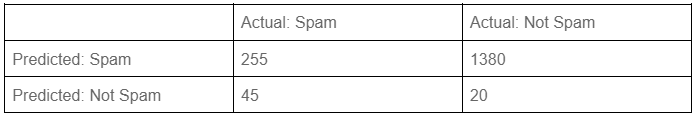
What is the F1 score of this classifier?

In [23]:
# define the confusion matrix
TP, FP, FN, TN = 255, 1380, 45, 20
pricission = TP/(TP + FP)
accuracy = TP/(TP + FN)
F1_score = round((2 * pricission * accuracy)/(pricission + accuracy), 4)
f'The F1 score of the classifier is {F1_score}'

'The F1 score of the classifier is 0.2636'

# Question 

What is the accuracy on the test set using the random forest classifier? In 4 decimal places.

In [24]:
# function for classification report and accuracy
def model_accuracy(model, X_train = normalized_X_train, y_train = y_train, X_test = normalized_X_test):
    model.fit(X_train, y_train)                                 # train model
    y_pred = model.predict(X_test)                              # test model
    print(f'Classification report for {model} is:')
    print(classification_report(y_test, y_pred, digits = 5))    # print classification_report
    print('')
    accuracy = round(accuracy_score(y_test, y_pred), 4)         # accuracy of model
    print(f'Accuracy is {accuracy}')                            # prints model accuracy
    return

In [25]:
# random forest classifier(rfc) accuracy
model_accuracy(rfc)

Classification report for RandomForestClassifier(random_state=1) is:
              precision    recall  f1-score   support

      stable    0.91765   0.87640   0.89655       712
    unstable    0.93333   0.95652   0.94479      1288

    accuracy                        0.92800      2000
   macro avg    0.92549   0.91646   0.92067      2000
weighted avg    0.92775   0.92800   0.92761      2000


Accuracy is 0.928


# Question 

What is the accuracy on the test set using the XGboost classifier? In 4 decimal places.

In [26]:
# XGboost classifier(xgbc) accuracy
model_accuracy(xgbc)

[10:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\zeez\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) is:
              precision    recall  f1-score   support

      stable    0.92438   0.84129   0.88088       712
    unstable    0.91642   0.96196   0.93864      1288

    accuracy                        0.91900      2000
   macro avg    0.92040   0.90162   0.90976      2000
weighted avg    0.91925   0.91900   0.91808      2000


Accuracy is 

# Question
Train a new ExtraTreesClassifier Model with the new Hyperparameters from the RandomizedSearchCV (with random_state = 1). Is the accuracy of the new optimal model higher or lower than the initial ExtraTreesClassifier model with no hyperparameter tuning?

In [27]:
# extra trees classifier model(extc) accuracy with no hyperparameter tuning
model_accuracy(extc)

Classification report for ExtraTreesClassifier(random_state=1) is:
              precision    recall  f1-score   support

      stable    0.94063   0.84551   0.89053       712
    unstable    0.91912   0.97050   0.94411      1288

    accuracy                        0.92600      2000
   macro avg    0.92987   0.90800   0.91732      2000
weighted avg    0.92677   0.92600   0.92504      2000


Accuracy is 0.926


In [28]:
# recall
# randomized search CV for extra trees classifier model
radomized_cv = RandomizedSearchCV(extc, hyperparameter,cv = 5, n_iter = 10, 
                                  scoring = 'accuracy', n_jobs = -1, verbose = 1, random_state = 1)
search_param = train_model(radomized_cv)
search_param.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': None}

In [29]:
# use the best parameters to train the dataset using extra trees classifier model
hypertuned_extc = ExtraTreesClassifier(**search_param.best_params_, random_state = 1)
hypertuned_extc.fit(normalized_X_train, y_train)
hypertund_y_pred = hypertuned_extc.predict(normalized_X_test)
accuracy = round(accuracy_score(y_test, hypertund_y_pred), 4)
print(f'Accuracy is {accuracy}')

Accuracy is 0.9285


#### The accuracy of the new optimal model is higher than the initial ExtraTreesClassifier model with no hyperparameter tuning.

# Question 19
What is the accuracy on the test set using the LGBM classifier? In 4 decimal places.

In [30]:
# LGBM classifier(lgbmc) accuracy
model_accuracy(lgbmc)

Classification report for LGBMClassifier(random_state=1) is:
              precision    recall  f1-score   support

      stable    0.92576   0.89326   0.90922       712
    unstable    0.94212   0.96040   0.95117      1288

    accuracy                        0.93650      2000
   macro avg    0.93394   0.92683   0.93020      2000
weighted avg    0.93630   0.93650   0.93624      2000


Accuracy is 0.9365
